# Защита персональных данных клиентов страховой компании

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, а также обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.

Целевой признак: количество страховых выплат клиенту за последние 5 лет.

## Загрузка и изучение данных

## Загрузка данных

In [5]:
import os
import numpy as np
import pandas as pd

import pandas_profiling
from pandas_profiling import ProfileReport

import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [6]:
pth1 = '/content/drive/MyDrive/data/insurance.csv'
pth2 = 'insurance.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
    print("Датасет успешно загружен с G-диска")
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
    print("Датасет успешно загружен с ЯндексПрактикум")
else:
    print("Проверьте правильность пути к датасету")

Датасет успешно загружен с ЯндексПрактикум


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Молодец что используешь конструкцию try - except (if - else), этим ты проявляешь уважение к тем кто будет работать с твоим кодом.

</div>

In [7]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Переименуем столбцы

In [8]:
df.columns = ['sex', 'age', 'salary', 'family_members', 'payments']

In [9]:
df.describe()

,sex,age,salary,family_members,payments
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             5000 non-null   int64  
 1   age             5000 non-null   float64
 2   salary          5000 non-null   float64
 3   family_members  5000 non-null   int64  
 4   payments        5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Пропусков нет. Два столбца с дробными значениями проверим

In [11]:
df.age.unique()

array([41., 46., 29., 21., 28., 43., 39., 25., 36., 32., 38., 23., 40.,
       34., 26., 42., 27., 33., 47., 30., 19., 31., 22., 20., 24., 18.,
       37., 48., 45., 44., 52., 49., 35., 56., 65., 55., 57., 54., 50.,
       53., 51., 58., 59., 60., 61., 62.])

In [12]:
df.salary.unique()

array([49600., 38000., 21000., 41700., 26100., 41000., 39700., 38600.,
       49700., 51700., 36600., 29300., 39500., 55000., 43700., 23300.,
       48900., 33200., 36900., 43500., 36100., 26600., 48700., 40400.,
       38400., 34600., 34800., 36800., 42200., 46300., 30300., 51000.,
       28100., 64800., 30400., 45300., 38300., 49500., 19400., 40200.,
       31700., 69200., 33100., 31600., 34500., 38700., 39600., 42400.,
       34900., 30500., 24200., 49900., 14300., 47000., 44800., 43800.,
       42700., 35400., 57200., 29600., 37400., 48100., 33700., 61800.,
       39400., 15600., 52600., 37600., 52500., 32700., 51600., 60900.,
       41800., 47400., 26500., 45900., 35700., 34300., 26700., 25700.,
       33300., 31100., 31500., 42100., 37300., 42500., 27300., 46800.,
       33500., 44300., 41600., 53900., 40100., 44600., 45000., 32000.,
       38200., 33000., 38500., 51800., 33800., 46400., 43200., 31800.,
       50200., 35100., 30700., 45800., 49300., 42800., 33600., 50300.,
      

Остальные столбцы целочисленные преобразуем весь датафрейм

In [13]:
df = df.astype(int)

Проверим на дубликаты

In [14]:
print('Кол-во дубликатов:', df.duplicated().sum(), "Доля дубликатов:", df.duplicated().sum() / len(df))

Кол-во дубликатов: 153 Доля дубликатов: 0.0306


In [15]:
df[df.duplicated()].sample(20)

,sex,age,salary,family_members,payments
4041,1,36,35000,1,0
3087,0,31,49400,1,0
1671,1,23,41900,2,0
3476,0,25,43400,0,0
2694,1,19,52600,0,0
3894,0,21,41700,2,0
2553,0,26,36100,1,0
4052,0,32,48700,2,0
4125,0,20,41500,2,0
869,1,24,33100,1,0


Данных для определения реальны ли дубликаты или совпадение - не достаточно, оставим как есть

In [16]:
profile = ProfileReport(df, progress_bar=False)

In [20]:
profile.to_file('report.html')

In [18]:
df.query('payments >= 4')

,sex,age,salary,family_members,payments
228,1,65,39700,1,5
1568,1,59,32100,0,4
2240,0,60,27900,0,4
3117,0,60,43400,2,4
3209,1,59,51700,2,4
3674,1,59,29600,0,4
3907,1,61,39600,1,4
4019,0,62,14100,0,4


Все клиенты которые получили от 4 выплат и выше были старше 59 лет.

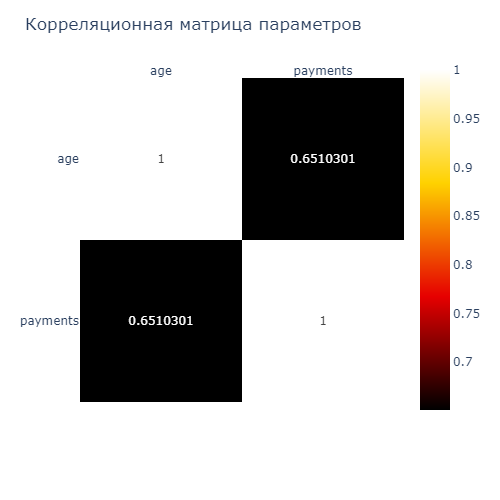

In [22]:
corr_matrix = df[['age', 'payments']].corr()

fig = px.imshow(corr_matrix,
                text_auto=True,
                width=600, 
                height=600,
                color_continuous_scale='Hot')
    
fig.update_xaxes(side="top")
fig.update_layout(title="Корреляционная матрица параметров")
fig.update_layout(width=500, height=500)
fig.show('png')

Наибольшая корреляция между целевым признаком и возрастом клиента

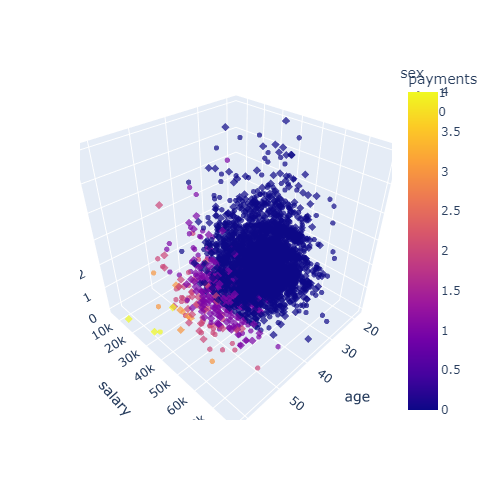

In [23]:
fig = px.scatter_3d(df.sample(n=3000), 
                    x='age', 
                    y='salary', 
                    z='family_members', 
                    color='payments',
                    symbol='sex',
                    opacity=0.7)
fig.update_traces(marker_size = 3)

fig.update_layout(width=500, height=500)
fig.show('png')

Видим довольно отчетливую закономерность между возрастом и количеством страховых выплат.

**Вывод:**
Нам представлена выборка с данными о 5000 клиентах, по 5 признаков. Преобразовали два столбца с целыми значениями в целочисленный тип. Явные дубликаты в таблице обнаружить затруднительно, примем что они отсутствуют.  Данные распределены, в целом, ожидаемо. Явных выбросов нет.
* Столбец пол - два значения, распределены примерно поровну
* Возраст клиентов от 18 до 65 лет. Чаще всего встречаются клиенты от 18 до 30 лет
* Доход клиентов распределен равномерно от 5300 до 79000 среднее и медиана около 40000
* Кол-во членов семьи распределено от 0 до 6, причем почти половину занимают одинокие или с одним членом семьи(или указавшие такие значения)
* Кол-во выплат - целевой признак, 88,7% клиентов не получали страховых выплат, максимальное значение 5 выплат и это всего у одного клиента.

## Умножение матриц

Приведем математическое доказательство того, что при преобразовании данных с помощью умножения на матрицу, линейная регрессия обработает их верно:

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Нам нужно доказать что данные до преобразования и после, соответственно:
$
a = a_k
$
, дадут одинаковый результат для линейной регрессии

Подставим формулу обучения в предсказаия:

$$
a = X (X^T X)^{-1} X^T y 
$$

Теперь для зашифрованых данных, полученных умножением на матрицу К

$$
a_k = XK((XK)^T XK)^{-1} (XK)^T y
$$

Пользуясь свойствами умножения на обратную матрицу, преобразуем выражение

$$
a_k = XK(K^TX^T XK)^{-1} K^TX^T y
$$

$$
a_k = XKK^{-1} (X^T X)^{-1} (K^T)^{-1} K^TX^T y
$$

сокращаем до единичных матриц:
$
KK^{-1}
$
и
$
(K^T)^{-1} K^T
$

и получаем ровно то же выражение что и для
$
a:
$

$$
a_k = X(X^T X)^{-1}X^T y
$$

соответственно, мы доказали, что 
$
a = a_k
$



**Ответ:** Преобразование данных умножением на матрицу не повлияет на результат работы линейной регрессии

## Алгоритм преобразования

**Алгоритм**

На основании выше преведенного доказательства для шифрования данных произведем следующие преобразования:

Для начала выберем размер ключа(матрицы для шифрования).

Исходя из условия того что наша матрица должна быть обратима и она должна будет умножаться на матрицу значений признаков с количеством столбцов 4, следовательно она должна быть квадратной и размером 4Х4. 

Для проверки на обратимость воспользуемся свойством детерминанта обратимой матрицы - он должен быть **не равен 0**

In [24]:
def cryptogenerator(train, test):
    det = 0
    while det == 0:
        matrix = np.random.normal(size=(train.shape[1], train.shape[1]))
        det = np.linalg.det(matrix)
    return np.matmul(train.values, matrix), np.matmul(test.values, matrix)

Подготовим и преобразуем признаки

In [25]:
X, y = df.drop(['payments'], axis=1), df['payments']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    shuffle=True)

print('Обучающая выборка:')
print('Доля от общего размера:', round(y_train.shape[0]/df.shape[0], 2))
print('Cтрок, столбцов:', X_train.shape)
print('Доля целевого признака:', round(y_train.mean(), 3))
print('- '*10)


print('Тестовая выборка:')
print('Доля от общего размера:', round(y_test.shape[0]/df.shape[0], 2))
print('Cтрок, столбцов:', X_test.shape)
print('Доля целевого признака:', round(y_test.mean(), 3))
print('-'*30)

Обучающая выборка:
Доля от общего размера: 0.75
Cтрок, столбцов: (3750, 4)
Доля целевого признака: 0.148
- - - - - - - - - - 
Тестовая выборка:
Доля от общего размера: 0.25
Cтрок, столбцов: (1250, 4)
Доля целевого признака: 0.148
------------------------------


Зашифруем признаки тренировочной и тестовой выборки

In [26]:
X_train_crypt, X_test_crypt = cryptogenerator(X_train, X_test)

Проверим результат

In [27]:
pd.DataFrame(X_train_crypt, columns=X_train.columns).head()

,sex,age,salary,family_members
0,15907.009473,-6626.208326,32223.937227,2432.904848
1,13178.358158,-5477.251436,26686.703577,2009.315090
2,17252.750657,-7180.825542,34945.704368,2635.430062
3,13690.464623,-5715.156313,27743.481219,2099.808161
4,16224.383400,-6759.554534,32867.163397,2482.635319


**Вывод** Данные подготовлены для проверки на модели. Алгоритм работает - данные зашифрованы.

## Проверка алгоритма

Проверим работу модели на исходных данных

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
score_notencryp = r2_score(y_test, pred)

И запустим модель на зашифрованных данных

In [29]:
model = LinearRegression()
model.fit(X_train_crypt, y_train)
pred = model.predict(X_test_crypt)
score_encryp = r2_score(y_test, pred)

Считаем разницу между предсказаниями

In [30]:
score_encryp - score_notencryp

4.781508522455624e-12

Ошибка получилась в пределах погрешности округления для чисел с плавающей запятой

**Вывод:**
В данном проекте нами проведена защита персональных данных клиентов страховой компании "Хоть Потоп"

На этапе подготовки привели данные к единому формату. Переименовалт столбцы для удобства дальнейшей работы. Проверили на дубликаты и корреляции между признаками.

При исследовании данных обнаружили зависимость между возрастом клиента и количеством страховых выплат. Чем старше клиент, тем больше выплат он получит.

Портрет идеального клиента возраст 18-40 остальные критерии влияют незначительно, далее чем старше тем больше страховых выплат придется выплатить клиенту. Первую выплату, в среднем, клиенты получают около 45 лет. Далее на каждые 5 лет жизни по одной выплате.

Для защиты персональных данных по условию был выбран шифр Хилла, подразумевающий умножение признаков на квадратную обратимую матрицу. При проверке данных после шифрования, с первого взгляда определить значения не удалось, следовательно шифр работает.

Далее мы привели математическое доказательство того, что выбранный способ не повлияет на результат работы линейной регрессии.

После обучения модели мы провели сравненение результатов работы модели на исходных и зашифрованных данных.
Результаты сопадают.

Для повышения стойкости шифрования рекомендуется также шифровать названия столбцов.

Итог - данный способ шифрования подходит для совместной работы с линейной регрессией.